In [1]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [2]:
import pandas as pd
df = pd.DataFrame(california.data, columns=california.feature_names)
df["MedHouseVal"] = california.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
import numpy as np
from scipy.stats import zscore

# Список колонок для перевірки на аномалії
cols = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
threshold = 3
z_scores = df[cols].apply(zscore)
mask = np.abs(z_scores) < threshold
rows_to_keep = mask.all(axis=1)
df_clean = df[rows_to_keep].copy()
print("Початковий розмір даних:", df.shape)
print("Розмір після видалення викидів:", df_clean.shape)


Початковий розмір даних: (20640, 9)
Розмір після видалення викидів: (20135, 9)


Матриця кореляцій:
               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.115877  0.656478  -0.167024   -0.020473 -0.062207   
HouseAge    -0.115877  1.000000 -0.215724  -0.125943   -0.289941 -0.000518   
AveRooms     0.656478 -0.215724  1.000000   0.300095   -0.086841 -0.042819   
AveBedrms   -0.167024 -0.125943  0.300095   1.000000   -0.045160 -0.081026   
Population  -0.020473 -0.289941 -0.086841  -0.045160    1.000000  0.177735   
AveOccup    -0.062207 -0.000518 -0.042819  -0.081026    0.177735  1.000000   
Latitude    -0.078484  0.009358  0.120207   0.067959   -0.118249 -0.139507   
Longitude   -0.016496 -0.101218 -0.073539   0.012771    0.107183  0.148333   
MedHouseVal  0.689414  0.105285  0.320290  -0.095212   -0.033585 -0.236810   

             Latitude  Longitude  MedHouseVal  
MedInc      -0.078484  -0.016496     0.689414  
HouseAge     0.009358  -0.101218     0.105285  
AveRooms     0.120207  -0.073539     0.320290  
AveBedrm

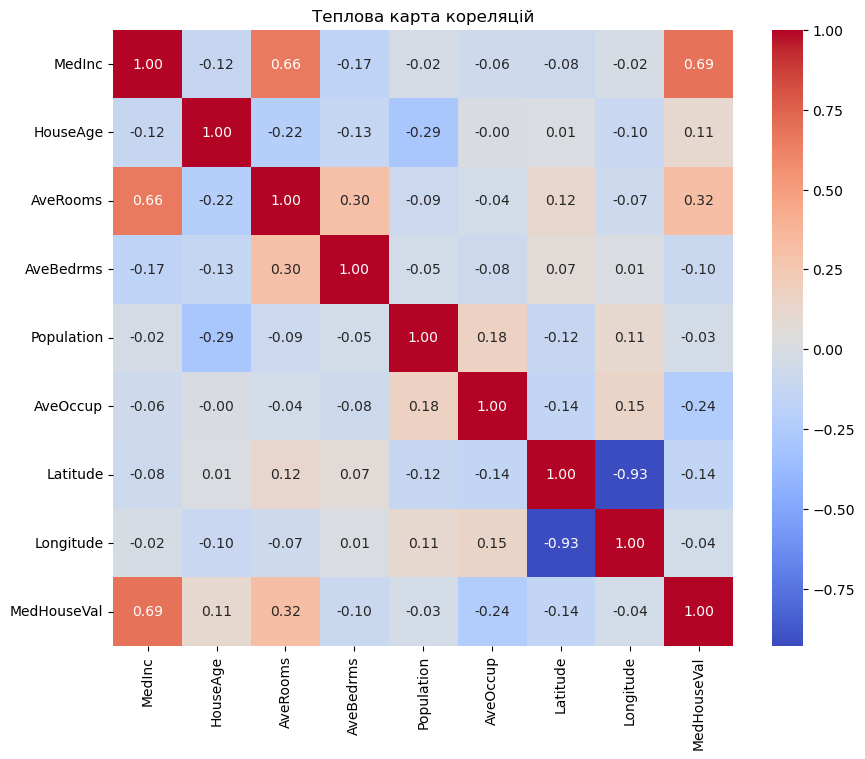

In [4]:
import seaborn as sns  
import matplotlib.pyplot as plt  # для побудови графіків
correlation_matrix = df_clean.corr()
print("Матриця кореляцій:")
print(correlation_matrix)

# Створюємо теплову карту (heatmap) для зручного перегляду кореляцій
plt.figure(figsize=(10, 8))  # налаштовуємо розмір графіка
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Теплова карта кореляцій")
plt.show()

In [5]:
df_review = df_clean.copy()
 
# from ydata_profiling import ProfileReport
# report = ProfileReport(
#     df_review,
#     title='California Housing Dataset')
# 
# report.to_notebook_iframe()

# ============
# В результаті експериментів я дійшов висновку що для підвищення стійкості моделі 
# потрібно видалити ознаку "AveRooms" оскільки вона має високу кореляцію з цільовою змінною, 
# а її видалення мінімально впливає на модель
# Видалення іншої ознаки "MedInc" яка також має високу кореляцію веде до значної деградації моделі. Тому її залишаємо

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Розділяємо дані на ознаки (X) та ціль (y)
X = df_review.drop(columns=["MedHouseVal", "AveRooms"])
y = df_review["MedHouseVal"]

# Розбиваємо на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------
# 1) Звичайна лінійна регресія (без поліноміальних ознак)
# -------------------------------------------------

# Створюємо копію, щоб не заплутатися з перетвореннями
X_train_lin = X_train.copy()
X_test_lin = X_test.copy()

# Масштабуємо дані
scaler_lin = StandardScaler()
X_train_lin_scaled = scaler_lin.fit_transform(X_train_lin)
X_test_lin_scaled = scaler_lin.transform(X_test_lin)

# Створюємо модель лінійної регресії
lin_model = LinearRegression()
# Навчаємо
lin_model.fit(X_train_lin_scaled, y_train)
# Передбачаємо
y_pred_lin = lin_model.predict(X_test_lin_scaled)

# Обчислюємо метрики
r2_lin = r2_score(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)

print("=== Лінійна регресія (без поліноміальних ознак) ===")
print(f"R2: {r2_lin:.2f} | MAE: {mae_lin:.2f} | MAPE: {mape_lin:.2f}\n")

# -------------------------------------------------
# 2) Лінійна регресія з поліноміальними ознаками
# -------------------------------------------------

poly_degree = 2
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)

# Генеруємо поліноміальні ознаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Масштабуємо поліноміальні ознаки
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# Створюємо модель лінійної регресії для поліноміальних ознак
poly_model = LinearRegression()
# Навчаємо
poly_model.fit(X_train_poly_scaled, y_train)
# Передбачаємо
y_pred_poly = poly_model.predict(X_test_poly_scaled)

# Обчислюємо метрики
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly)

print(f"=== Поліноміальна регресія (ступінь = {poly_degree}) ===")
print(f"R2: {r2_poly:.2f} | MAE: {mae_poly:.2f} | MAPE: {mape_poly:.2f}")

=== Лінійна регресія (без поліноміальних ознак) ===
R2: 0.65 | MAE: 0.51 | MAPE: 0.30

=== Поліноміальна регресія (ступінь = 2) ===
R2: 0.70 | MAE: 0.47 | MAPE: 0.27


### Висновок:

| Модель                                     | R²   | MAE  | MAPE |
|-------------------------------------------|------|------|------|
| Лінійна регресія (без поліномів)         | 0.65 | 0.51 | 0.30 |
| Поліноміальна регресія (ступінь=2)       | 0.70 | 0.47 | 0.27 |
| Поліноміальна регресія (ступінь=3)       | 0.71 | 0.43 | 0.25 |

**Зауваження:**  
- При підготовці даних до тренування **було видалено ознаку "AveRooms"** через високу кореляцію з цільовою змінною.  
- Поліноміальні ознаки (до 3-го ступеня) покращили R² і знизили похибки, але можуть призвести до перенавчання. Тому я вирішив залишити степінь 2.  